In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import emcee
import corner
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

In [2]:
fluxes = np.load("transient.npy")

Text(0, 0.5, 'flux')

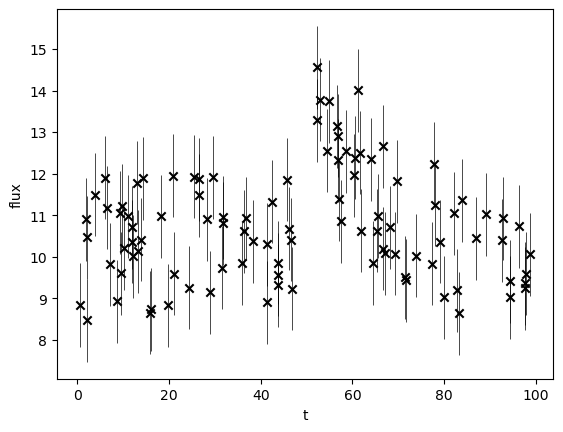

In [3]:
plt.errorbar(fluxes[:, 0], fluxes[:, 1], yerr=fluxes[:, 2], linestyle="none", color="black", linewidth=0.5)
plt.scatter(fluxes[:, 0], fluxes[:, 1], marker="x", color="black")
plt.xlabel("t")
plt.ylabel("flux")

In [4]:
#par = [t0, b, A, alpha]

In [5]:
def burst(par, t):
    if t>par[0]:
        f = par[1]+par[2]*np.exp(-par[3]*(t-par[0]))
    if t<par[0]:
        f = par[1]
    return f

In [6]:
def log_likelihood(par, t, flux, err, model):
    L = 0
    for i in range(len(flux)):
        L = L+(((flux[i]-model(par, t[i]))**2)/err[i])
    return -L/2

Text(0, 0.5, 'flux')

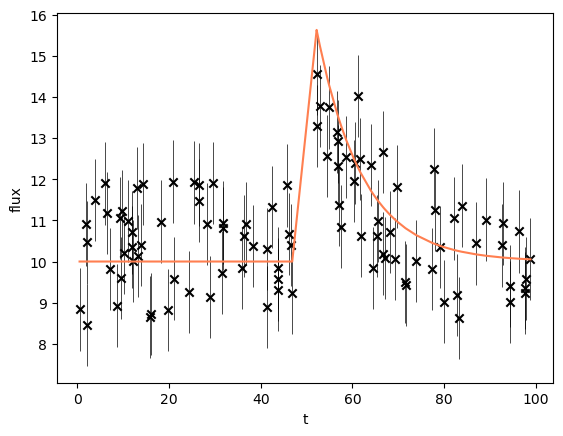

In [7]:
t0_guess = 50
b_guess = 10
A_guess = 7
alpha_guess = 0.1
par_guess = [t0_guess, b_guess, A_guess, alpha_guess]

y = np.zeros(len(fluxes))
for i in range(len(fluxes)):
    y[i] = burst(par_guess, fluxes[i, 0])

plt.errorbar(fluxes[:, 0], fluxes[:, 1], yerr=fluxes[:, 2], linestyle="none", color="black", linewidth=0.5)
plt.scatter(fluxes[:, 0], fluxes[:, 1], marker="x", color="black")
plt.plot(fluxes[:, 0], y, color="coral")
plt.xlabel("t")
plt.ylabel("flux")

In [8]:
log_likelihood(par_guess, fluxes[:, 0], fluxes[:, 1], fluxes[:, 2], burst)

-61.4161037054536

$b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$

$p(y) = \left|dy/dx\right|^{-1}p(x)$

$x = \ln\alpha$

$y = e^{x} = \alpha$

$p(y) = \left|\frac{dx}{dy}\right| p(x) = \frac{\mathrm{Uniform}[-5,5]}{\alpha}$

In [9]:
t0min, t0max = 0, 100
Amin, Amax = 0, 50
bmin, bmax = 0, 50
alphamin, alphamax = np.exp(-5), np.exp(5)

In [10]:
def log_prior(par):
    t0, b, A, alpha = par
    if Amin < A < Amax and bmin < b < bmax and t0min < t0 < t0max and alphamin < alpha < alphamax:
        return 0.0+0.0+0.0-np.log(alpha)
    return -np.inf

def log_posterior(par, t, flux, err, model):
    return log_likelihood(par, t, flux, err, model)+log_prior(par)

N_dim = 4  # number of parameters in the model
N_walkers = 10 # number of MCMC walkers
burn_in = 10000  # "burn-in" period to let chains stabilize
N_steps = 100000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = par_guess*np.random.random((N_walkers, N_dim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(N_walkers, N_dim, log_posterior, args=[fluxes[:, 0], fluxes[:, 1], fluxes[:, 2], burst])
sampler.run_mcmc(starting_guesses, N_steps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn_in:, :].reshape(-1, N_dim)

Text(0.5, 0, 'step number')

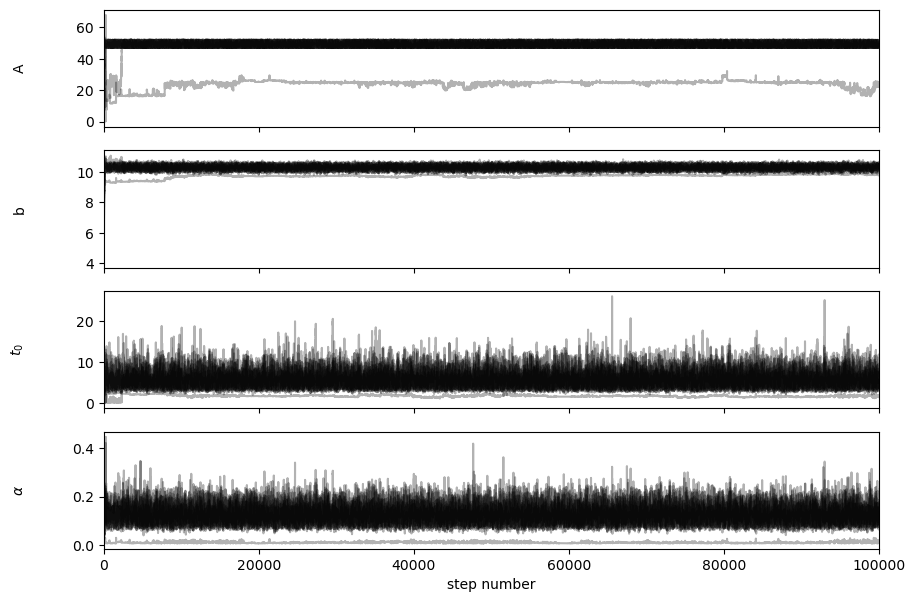

In [16]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A","b","$t_0$","$\\alpha$"]
for i in range(N_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

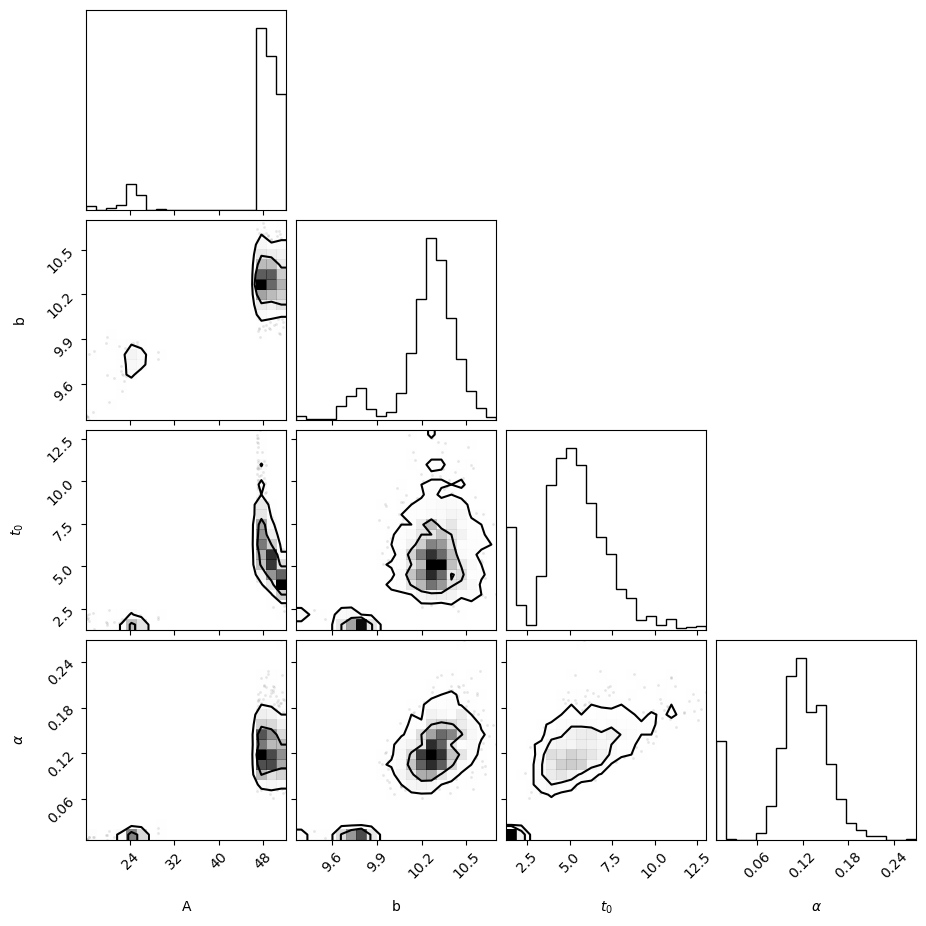

In [17]:
tau = sampler.get_autocorr_time()
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
fig = corner.corner(flat_samples, labels=labels, levels=[0.68,0.95])

In [30]:
def gprofile(par, t):
    t0, b, A, sigmaW = par     
    return b+A*np.exp(-(((t-t0)/sigmaW)**2 ) / 2)

sigmaWmin, sigmaWmax = np.exp(-2), np.exp(2)

In [22]:
N_dim = 4

def ptform(u, model):
    x = np.array(u)

    x[0] = stats.uniform(loc=Amin, scale=Amax-Amin).ppf(u[0])
    x[1] = stats.uniform(loc=bmin, scale=bmax-bmin).ppf(u[1])
    x[2] = stats.uniform(loc=t0min, scale=t0max-t0min).ppf(u[2])
   
    if model == "burst":
        x[3] = stats.loguniform.ppf(u[3], alphamin, alphamax)
    elif model == "gprofile":
        x[3] = stats.loguniform.ppf(u[3], sigmaWmin, sigmaWmax)
        #x[3] = stats.uniform(loc=sigmaWmin,scale=sigmaWmax-sigmaWmin).ppf(u[3])

    return x

In [24]:
#as before
sampler = dynesty.NestedSampler(log_likelihood, ptform, N_dim, logl_args=[fluxes[:, 0], fluxes[:, 1], fluxes[:, 2],burst], ptform_args=["burst"], nlive=300)
sampler.run_nested()
sresults = sampler.results

1853it [02:18, 13.34it/s, bound: 19 | nc: 12 | ncall: 19011 | eff(%):  9.747 | loglstar:   -inf < -87.963 <    inf | logz: -95.123 +/-  0.145 | dlogz: 30.939 >  0.309]       C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
1866it [02:48,  1.33s/it, bound: 27 | nc: 167 | ncall: 22532 | eff(%):  8.282 | loglstar:   -inf < -87.897 <    inf | logz: -95.011 +/-  0.145 | dlogz: 30.784 >  0.309] C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are usin

2046it [04:18,  2.22s/it, bound: 52 | nc: 105 | ncall: 33822 | eff(%):  6.049 | loglstar:   -inf < -87.270 <    inf | logz: -94.061 +/-  0.142 | dlogz: 29.229 >  0.309] C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
2047it [04:20,  1.92s/it, bound: 53 | nc: 132 | ncall: 33954 | eff(%):  6.029 | loglstar:   -inf < -87.268 <    inf | logz: -94.057 +/-  0.142 | dlogz: 29.223 >  0.309]C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using unif

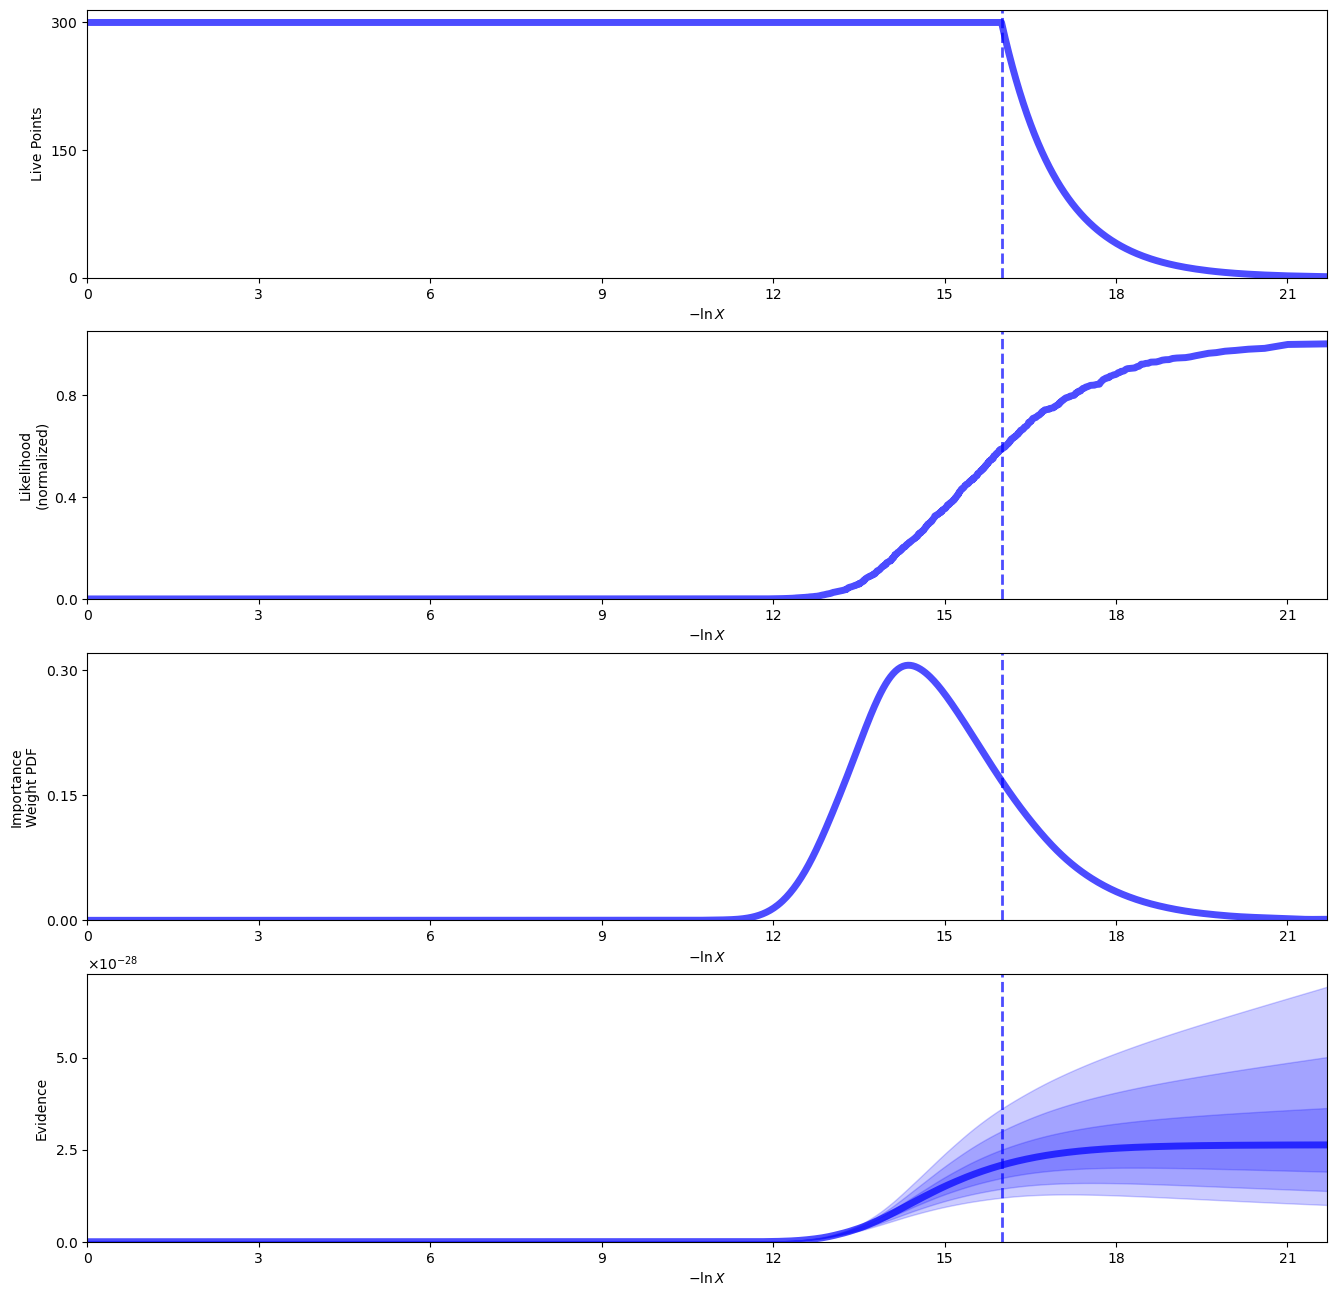

In [25]:
rfig, raxes = dyplot.runplot(sresults)

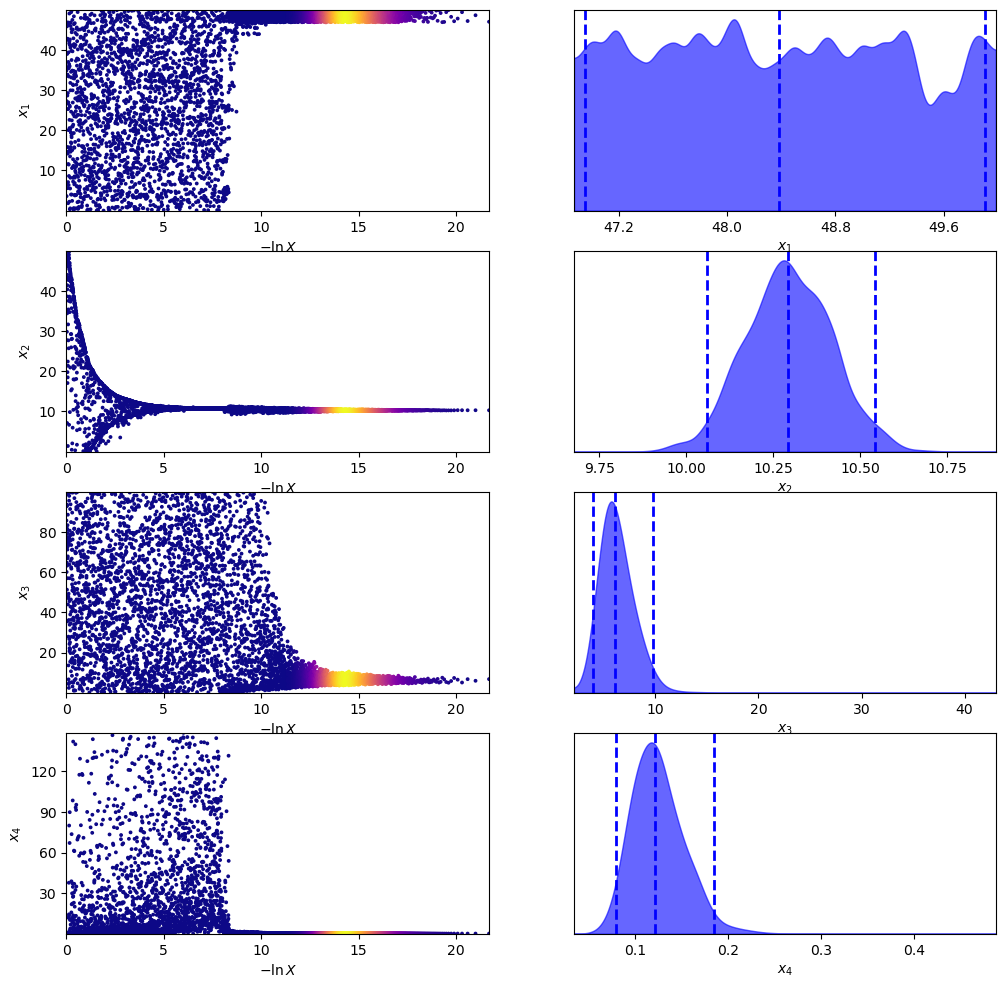

In [26]:
tfig, taxes = dyplot.traceplot(sresults)

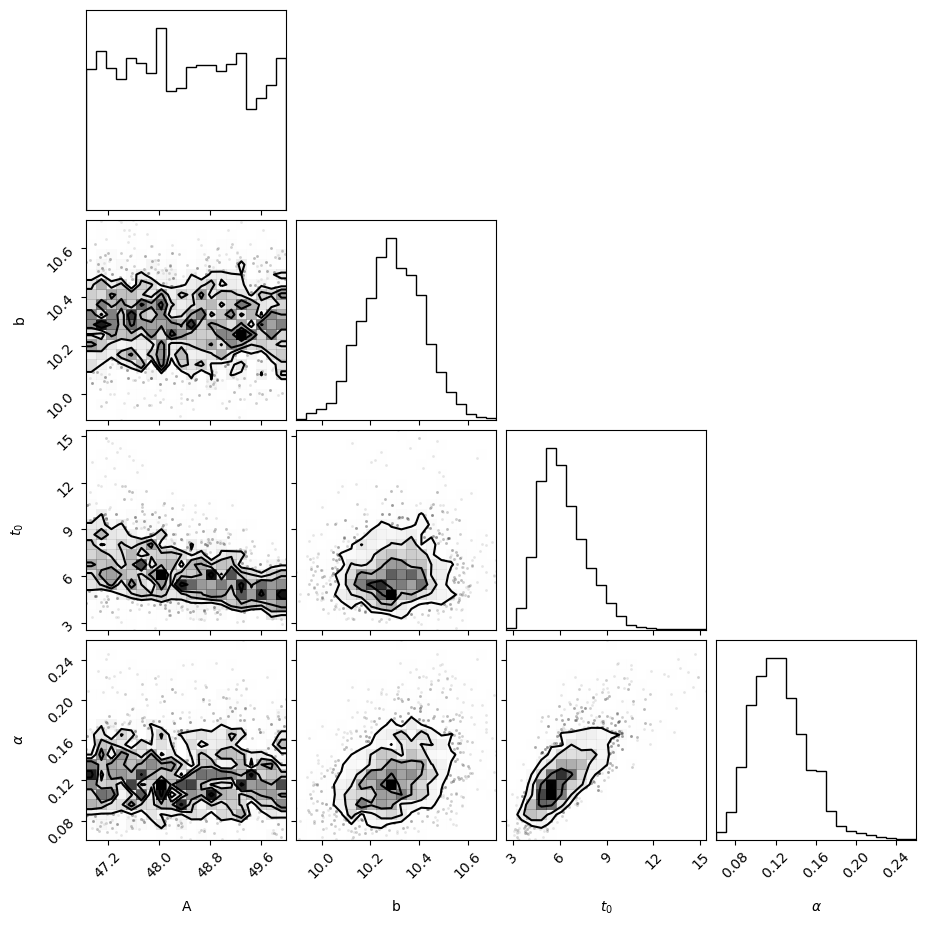

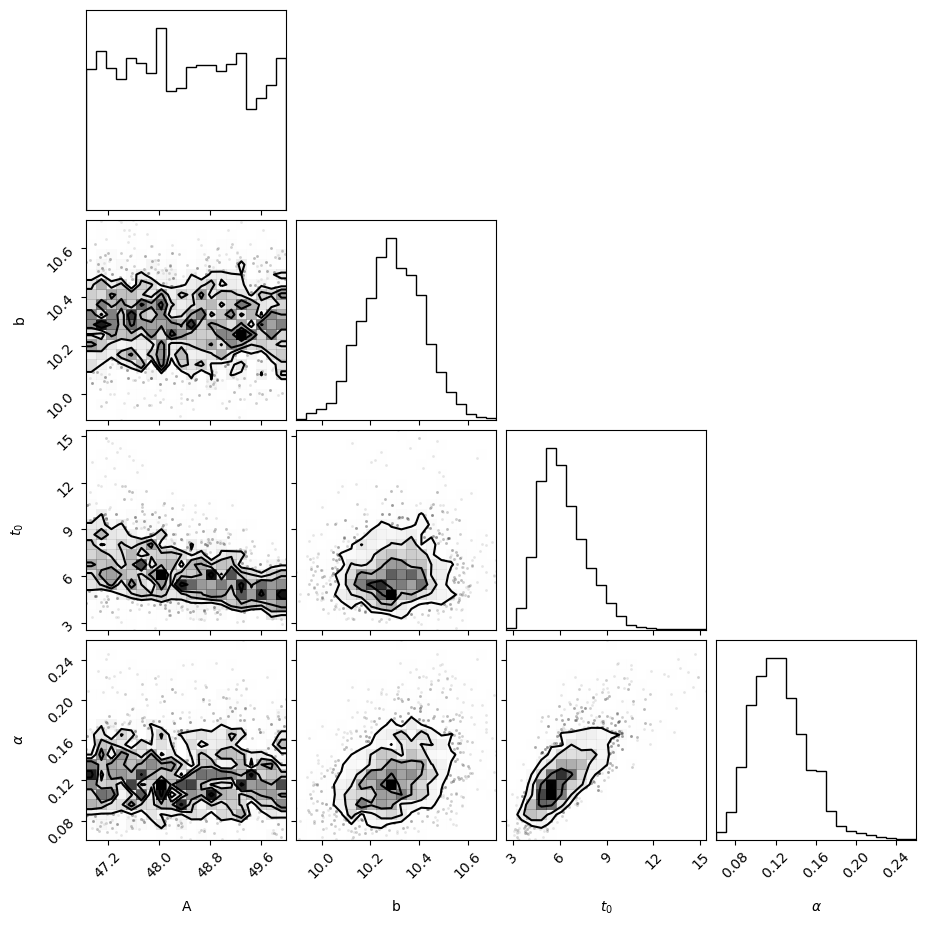

In [27]:
samples = sresults.samples
weights = np.exp(sresults.logwt - sresults.logz[-1])

labels = ["A", "b", "$t_0$","$\\alpha$"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels)

In [31]:
#Gaussian
sampler = dynesty.NestedSampler(log_likelihood, ptform, N_dim,logl_args=[fluxes[:, 0], fluxes[:, 1], fluxes[:, 2], gprofile],ptform_args=["gprofile"],nlive=300)
sampler.run_nested()
sresults2 = sampler.results

2475it [06:06,  1.34it/s, bound: 77 | nc: 81 | ncall: 45195 | eff(%):  5.476 | loglstar:   -inf < -87.243 <    inf | logz: -95.047 +/-  0.153 | dlogz: 11.396 >  0.309]     C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
2599it [07:19,  5.29it/s, bound: 96 | nc: 12 | ncall: 53772 | eff(%):  4.833 | loglstar:   -inf < -87.148 <    inf | logz: -94.840 +/-  0.152 | dlogz: 10.776 >  0.309]  C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using 

C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: 

C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: 

4963it [32:21,  1.12s/it, bound: 496 | nc: 19 | ncall: 233811 | eff(%):  2.123 | loglstar:   -inf < -74.995 <    inf | logz: -89.633 +/-  0.206 | dlogz:  1.146 >  0.309] C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
4967it [32:28,  1.56s/it, bound: 498 | nc: 204 | ncall: 234707 | eff(%):  2.116 | loglstar:   -inf < -74.983 <    inf | logz: -89.631 +/-  0.206 | dlogz:  1.136 >  0.309]C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using u

C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: 

5584it [35:21,  2.63it/s, +300 | bound: 542 | nc: 1 | ncall: 254545 | eff(%):  2.314 | loglstar:   -inf < -71.811 <    inf | logz: -89.251 +/-  0.233 | dlogz:  0.001 >  0.309]


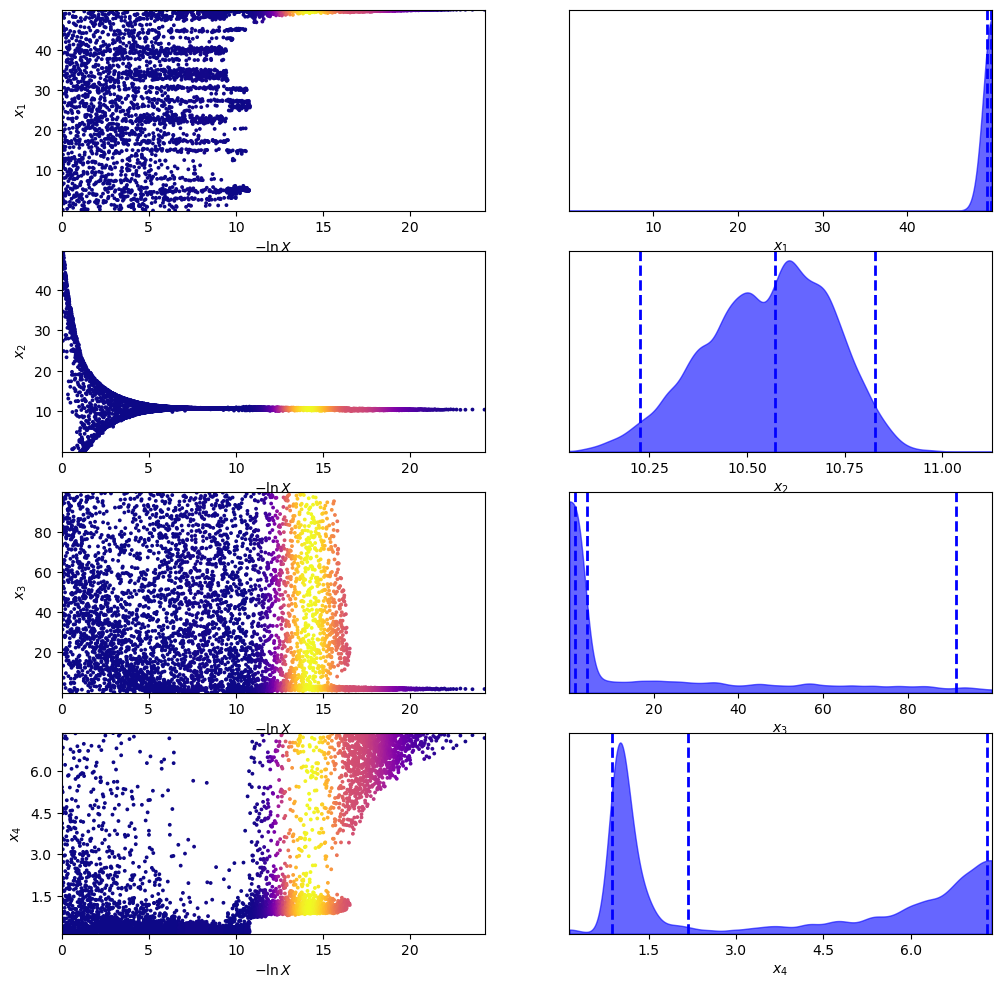

In [32]:
tfig, taxes = dyplot.traceplot(sresults2)

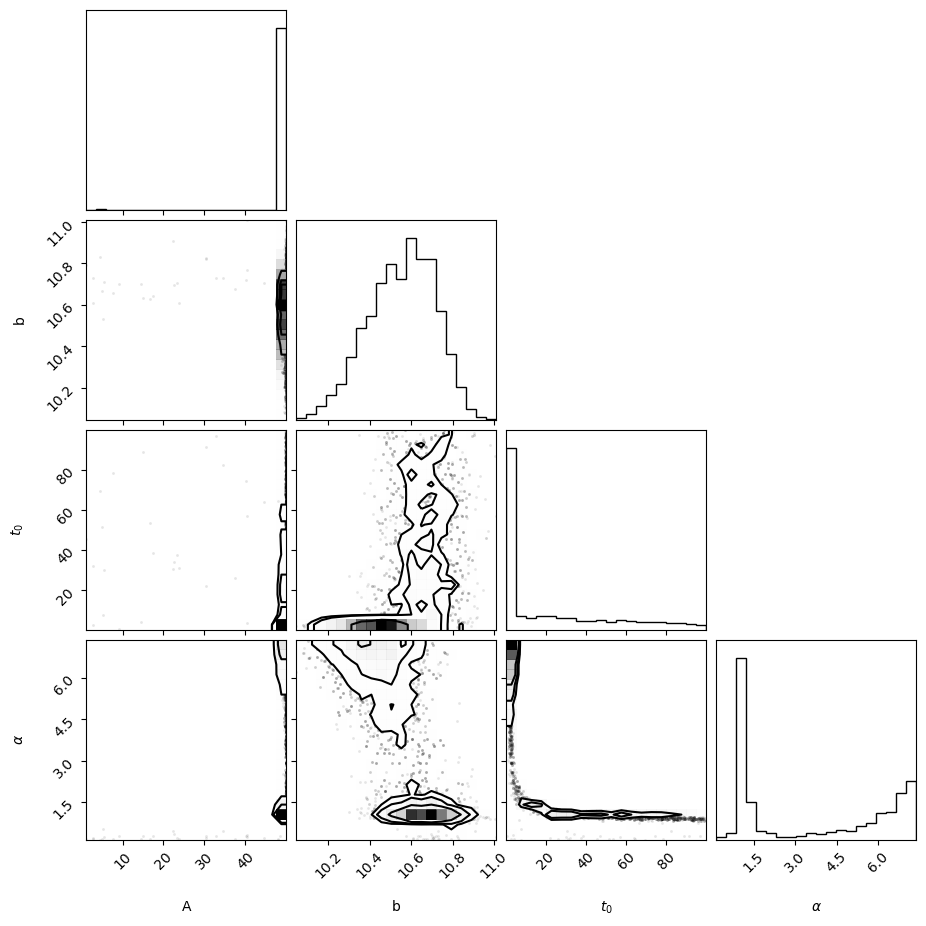

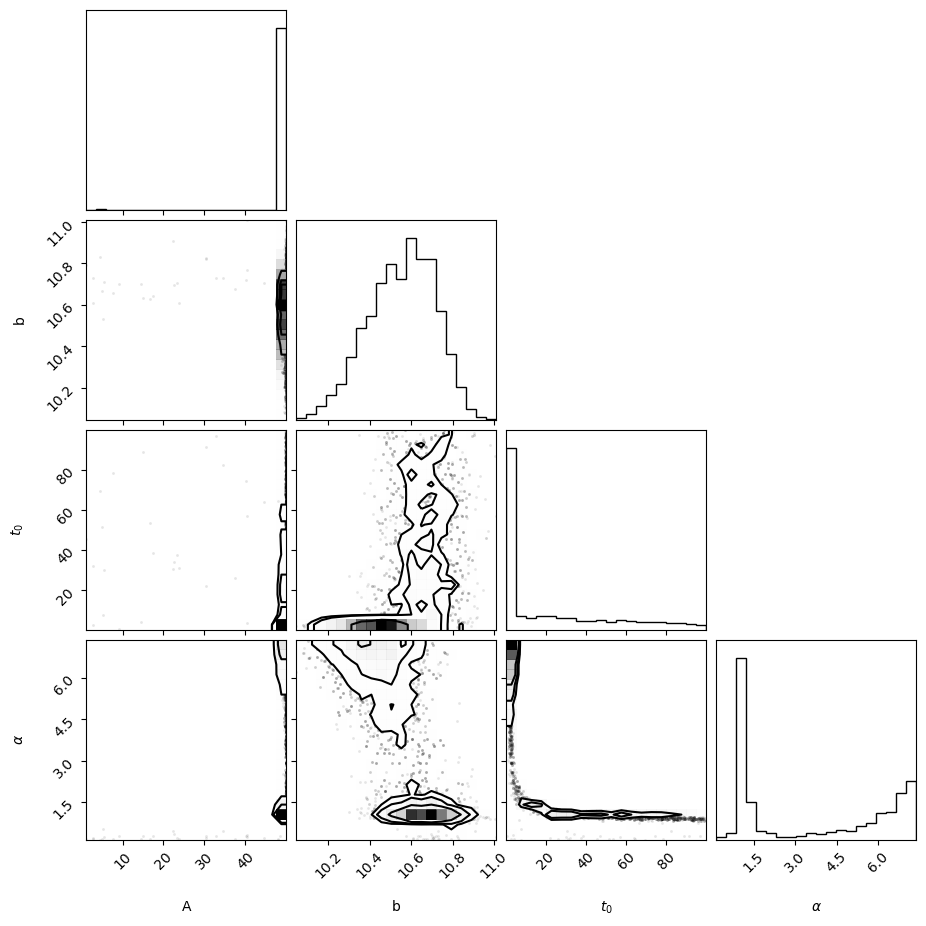

In [33]:
samples = sresults2.samples  # samples
weights = np.exp(sresults2.logwt - sresults2.logz[-1])  # normalized weights

labels = ["A", "b", "$t_0$","$\\alpha$"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels)

In [34]:
#odds ratio
np.exp(sresults.logz[-1])/np.exp(sresults2.logz[-1])
#burst model favoured

151747354411.63052